In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance

In [2]:
df = pd.read_csv('../../../data/preprocessed/feature_selection_by_model_final_data_30feature.csv')

In [3]:
X = df.drop(['price_per_m2'], axis=1)
y = df['price_per_m2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
svm_pipeline = make_pipeline(
    StandardScaler(),
    SVR()
)

In [5]:
param_grid = {
    'svr__kernel': ['rbf', 'poly', 'sigmoid'],
    'svr__C': [0.1, 1, 10, 100],
    'svr__epsilon': [0.01, 0.1, 0.5, 1],
    'svr__gamma': ['scale', 'auto'] + list(np.logspace(-3, 1, 5))
}

In [6]:
def objective(trial):
    params = {
        'svr__kernel': trial.suggest_categorical('kernel', ['rbf', 'poly', 'sigmoid']),
        'svr__C': trial.suggest_float('C', 0.1, 100, log=True),
        'svr__epsilon': trial.suggest_float('epsilon', 0.01, 1.0),
        'svr__gamma': trial.suggest_categorical('gamma', ['scale', 'auto']) or trial.suggest_float('gamma', 1e-3, 10, log=True)
    }
    model = make_pipeline(
        StandardScaler(),
        SVR(**{k.split('__')[1]: v for k, v in params.items()})
    )
    score = cross_val_score(
        model, 
        X_train, 
        y_train, 
        cv=3,  # Reduced for computational efficiency
        scoring='r2', 
        n_jobs=-1
    ).mean()
    return score
print("\nStarting SVM optimization with Optuna...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2025-07-03 09:12:14,380] A new study created in memory with name: no-name-ff29e4bd-955e-4682-afee-4d7ca900b9fa



Starting SVM optimization with Optuna...


[I 2025-07-03 09:12:25,170] Trial 0 finished with value: 0.8952336351151581 and parameters: {'kernel': 'rbf', 'C': 70.69261073690929, 'epsilon': 0.6281580426901975, 'gamma': 'auto'}. Best is trial 0 with value: 0.8952336351151581.
[I 2025-07-03 09:12:32,213] Trial 1 finished with value: 0.8044600749424449 and parameters: {'kernel': 'sigmoid', 'C': 11.042566817476487, 'epsilon': 0.7880182042537807, 'gamma': 'scale'}. Best is trial 0 with value: 0.8952336351151581.
[I 2025-07-03 09:12:40,569] Trial 2 finished with value: -0.18995492845432435 and parameters: {'kernel': 'rbf', 'C': 0.12359359016998696, 'epsilon': 0.40255818311542985, 'gamma': 'auto'}. Best is trial 0 with value: 0.8952336351151581.
[I 2025-07-03 09:12:49,850] Trial 3 finished with value: -0.07512944905443623 and parameters: {'kernel': 'sigmoid', 'C': 0.24440664198238304, 'epsilon': 0.044207273919166734, 'gamma': 'auto'}. Best is trial 0 with value: 0.8952336351151581.
[I 2025-07-03 09:12:55,127] Trial 4 finished with value

In [7]:
best_params = study.best_params
optimized_svm = make_pipeline(
    StandardScaler(),
    SVR(
        kernel=best_params['kernel'],
        C=best_params['C'],
        epsilon=best_params['epsilon'],
        gamma=best_params['gamma']
    )
)

In [8]:
optimized_svm.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr',
                 SVR(C=93.1179846035902, epsilon=0.9234431864368682,
                     kernel='sigmoid'))])

In [9]:
# Final evaluation function
def evaluate_model(model, X, y_true):
    y_pred = model.predict(X)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-8))) * 100  # Avoid division by zero
    print(f"R²: {r2:.4f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"Avg Price: {y_true.mean():.2f}")
    return y_pred

In [10]:
print("\nOptimized SVM Performance:")
y_pred_svm = evaluate_model(optimized_svm, X_test, y_test)


Optimized SVM Performance:
R²: 0.9559
MAE: 240.22
MAPE: 19.80%
Avg Price: 1936.11


In [11]:
# Model interpretation using permutation importance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
fitted_svr = SVR(
    kernel=best_params['kernel'],
    C=best_params['C'],
    epsilon=best_params['epsilon'],
    gamma=best_params['gamma']
).fit(X_train_scaled, y_train)


In [13]:
result = permutation_importance(
    fitted_svr, 
    X_test_scaled, 
    y_test, 
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

C:\Users\User\AppData\Local\Temp\ipykernel_11564\1785586516.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


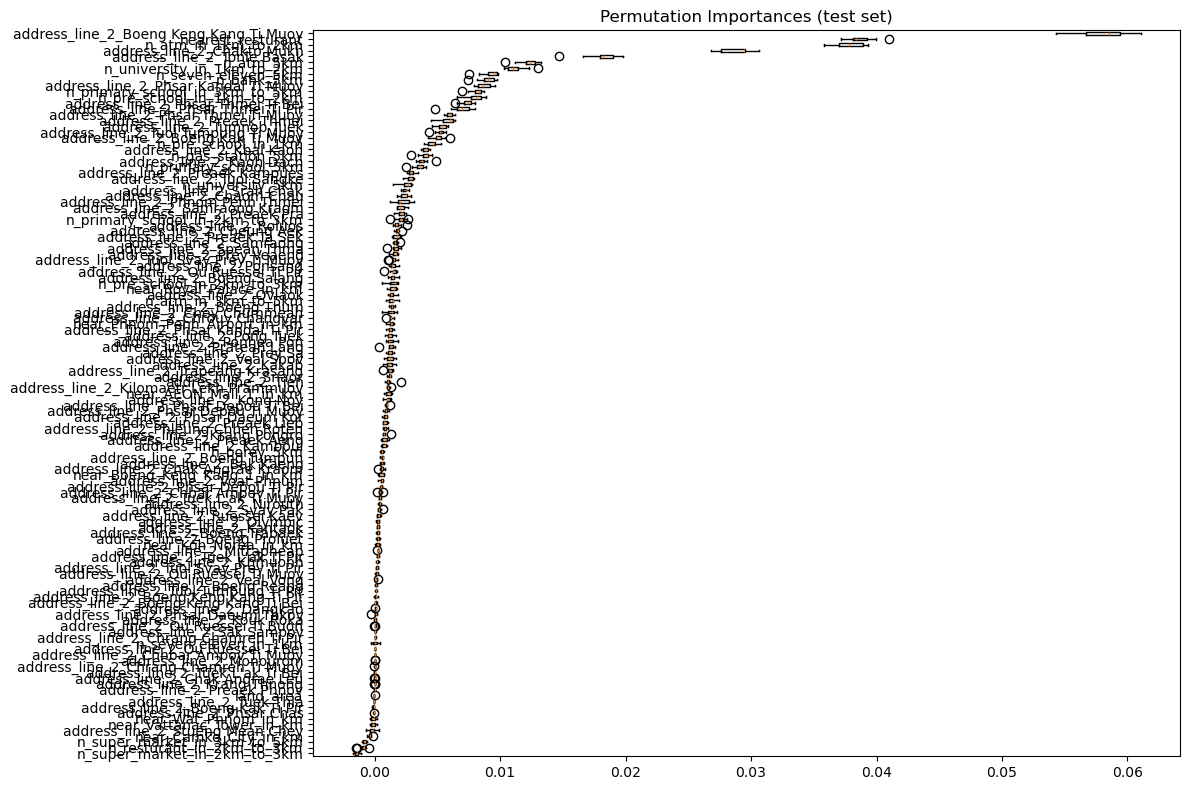

In [14]:

# Plot feature importance
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(12, 8))
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=X.columns[sorted_idx]
)
plt.title("Permutation Importances (test set)")
plt.tight_layout()
plt.savefig("svm_feature_importance.png")
plt.show()

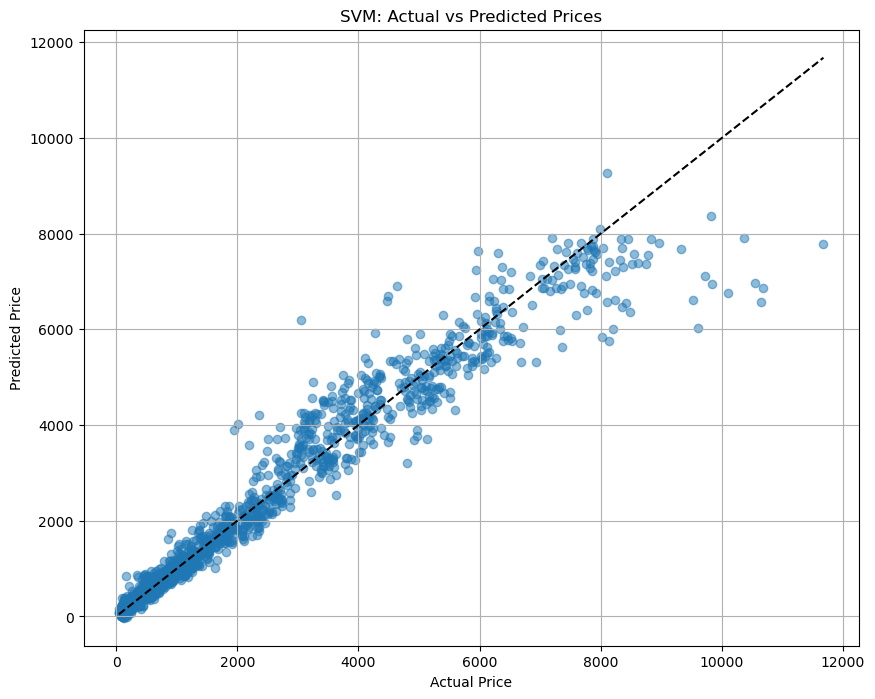

In [15]:
# Actual vs Predicted plot
def plot_actual_vs_predicted(y_true, y_pred):
    plt.figure(figsize=(10, 8))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], 
             [y_true.min(), y_true.max()], 'k--')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title('SVM: Actual vs Predicted Prices')
    plt.grid(True)
    plt.savefig("svm_actual_vs_predicted.png")
    plt.show()

plot_actual_vs_predicted(y_test, y_pred_svm)
